# Nettoyage

#### Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from numpy import isnan

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#### Message d'avertissements

In [2]:
warnings.filterwarnings("ignore")

#### Dimension des dataframes

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

#### Import CSV Data

In [4]:
data = pd.read_csv("./Data/en1.openfoodfacts.org.products.csv", sep='\t')
data.shape

(253678, 197)

## Préparation des données

#### Vérification des doubles

In [5]:
data.loc[data.duplicated(keep=False)].shape

(0, 197)

In [6]:
data.loc[data["product_name"].duplicated(keep=False)].shape

(77602, 197)

#### Format des colonnes

In [7]:
data.shape

(253678, 197)

In [8]:
data_b = data.copy()

In [9]:
for n in data_b.columns:
    i = re.search("_datetime$",n)
    t =  re.search("_t$",n)
    if i:
        data_b[n] = pd.to_datetime(data_b[n], errors='coerce')
    if t:
        data_b[n] = pd.to_datetime(data_b[n], errors='coerce', unit='s')
        
data_b.dtypes

Unnamed: 0                                                             int64
code                                                                  object
url                                                                   object
creator                                                               object
created_t                                                     datetime64[ns]
created_datetime                                         datetime64[ns, UTC]
last_modified_t                                               datetime64[ns]
last_modified_datetime                                   datetime64[ns, UTC]
product_name                                                          object
abbreviated_product_name                                              object
generic_name                                                          object
quantity                                                              object
packaging                                                             object

In [10]:
data_b.head()

,Unnamed: 0,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_en,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,ingredients_tags,ingredients_analysis_tags,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_score,ecoscore_grade,nutrient_levels_tags,product_quantity,owner,data_quality_errors_tags,unique_scans_n,popularity_tags,completeness,last_image_t,last_image_datetime,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,8192,11110024800,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,2017-03-09 13:11:25,2017-03-09 13:11:25+00:00,2022-02-08 01:35:53,2022-02-08 01:35:53+00:00,Sea salt roasted deluxe nut mix,NaN,NaN,16 oz,NaN,NaN,NaN,NaN,Simple Truth Organic,simple-truth-organic,Snacks,en:snacks,Snacks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States,"Cashews, almonds, pecans, brazil nuts, vegetab...","en:cashew-nuts,en:nut,en:tree-nut,en:almond,en...","en:palm-oil-free,en:vegan-status-unknown,en:ve...",NaN,NaN,NaN,NaN,NaN,0.25 cup (28 g),28.0,NaN,0.0,NaN,NaN,NaN,13.0,d,3.0,unknown,unknown,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be 

### Variables d'intérêt

#### Sélections des variables d'interet

In [11]:
var_int  = ['code',
            'product_name',
            'nova_group',
            'nutriscore_score',
            'nutriscore_grade',
            'energy_100g',
            'fat_100g', 
            'saturated-fat_100g', 
            'trans-fat_100g', 
            'carbohydrates_100g', 
            'sugars_100g',
            'fiber_100g',
            'proteins_100g', 
            'salt_100g',
            'sodium_100g',
            'alcohol_100g', 
            'fruits-vegetables-nuts_100g',
            'ingredients_text',
            'additives_n',
            'url']

In [12]:
data_int = data_b[var_int]

In [13]:
data_int.shape

(253678, 20)

#### Visualisation

In [14]:
def visu(dataf) : # Fonction visualisation du taux de remplissage
    df = pd.DataFrame(index=['Valeurs manquantes','Nombre de valeurs' ,'Taux de remplissage','Valeurs différentes'], columns= dataf.columns )
    
    for v in dataf.columns:
        #Somme des valeurs manquantes
        df.loc['Valeurs manquantes', v] = dataf[v].isnull().sum()
        # Nombre de valeurs 
        df.loc['Nombre de valeurs', v] = dataf.shape[0] - dataf[v].isnull().sum()
        #Taux de remplissage en %
        df.loc['Taux de remplissage', v] =((dataf.shape[0]- dataf[v].isnull().sum())/(dataf.shape[0]*1.0))*100 
        # Nombre de valeurs différentes
        df.loc['Valeurs différentes', v] = dataf[v].nunique()
        
    df1 = df.T #Tranposition du Dataframe
    # Conversion du type des colonnes
    df1['Valeurs manquantes'] = df1['Valeurs manquantes'].astype(int) 
    df1['Nombre de valeurs'] = df1['Nombre de valeurs'].astype(int)
    df1['Taux de remplissage'] = df1['Taux de remplissage'].astype(float)
    df1['Valeurs différentes'] = df1['Valeurs différentes'].astype(int)
    df1 = df1.sort_values(by=['Taux de remplissage'], ascending = False)
    
    plt.figure(figsize= (10,8))
    sns.set_theme()
    sns.barplot(df1["Taux de remplissage"], y=df1.index, palette="YlOrBr_r")
    plt.xlabel("Taux de remplissage en (%)", fontsize=13)
    plt.ylabel("Colonnes", fontsize=13)
    plt.title("Taux de replissage des colonnes", fontsize=16)
    plt.axvline(x=20, color='w')
    plt.axvline(x=80, color='w')
    plt.savefig("./Visualisations/Taux {}".format('dataf'), bbox_inches='tight')
    
    plt.show()
    
    return df
    

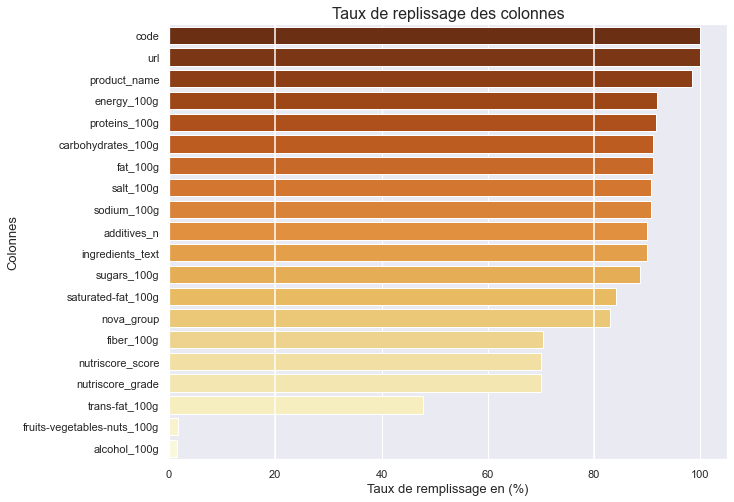

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
Valeurs manquantes,0,4047,43100,76317,76317,20688,22576,40190,132295,22544,28734,75239,21325,23453,23455,249703,249177,25621,25621,0
Nombre de valeurs,253678,249631,210578,177361,177361,232990,231102,213488,121383,231134,224944,178439,232353,230225,230223,3975,4501,228057,228057,253678
Taux de remplissage,100.0,98.40467,83.009958,69.915799,69.915799,91.84478,91.100529,84.157081,47.849242,91.113143,88.673042,70.340747,91.593674,90.754815,90.754027,1.566947,1.774297,89.900188,89.900188,100.0
Valeurs différentes,253568,194440,4,54,5,3518,4499,2938,383,7221,5410,1482,3548,9282,9131,145,738,191676,33,253677


In [15]:
visu(data_int)

In [16]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,210578.000000,177361.000000,232990.000000,231102.000000,213488.000000,121383.000000,231134.000000,224944.000000,178439.000000,232353.000000,230225.000000,230223.000000,3975.000000,4501.000000,228057.000000
mean,3.394144,8.698953,1112.028673,12.590017,4.881025,0.062555,31.398513,15.397394,2.798055,6.987972,1.703730,0.681741,5.901007,35.869619,2.153251
std,0.989319,9.055363,1309.268639,17.425891,7.967074,1.521843,29.644187,23.328760,4.578154,8.090268,15.811335,6.325796,9.707120,37.722262,3.004094
min,1.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,-6.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,364.000000,0.010000,0.000000,0.000000,5.420000,1.000000,0.000000,0.700000,0.052500,0.021000,0.000000,0.000000,0.000000
50%,4.000000,9.000000,1071.000000,4.950000,1.610000,0.000000,20.000000,5.000000,1.500000,4.650000,0.532500,0.213000,0.100000,22.000000,1.000000
75%,4.000000,15.000000,1672.000000,20.000000,7.000000,0.000000,57.450000,22.800000,3.600000,10.000000,1.322500,0.529000,8.500000,65.000000,3.000000
max,4.000000,38.000000,500000.000000,110.000000,910.000000,369.000000,2916.670000,4950.000000,250.000000,175.000000,3250.000000,1300.000000,100.000000,100.000000,32.000000


<AxesSubplot:>

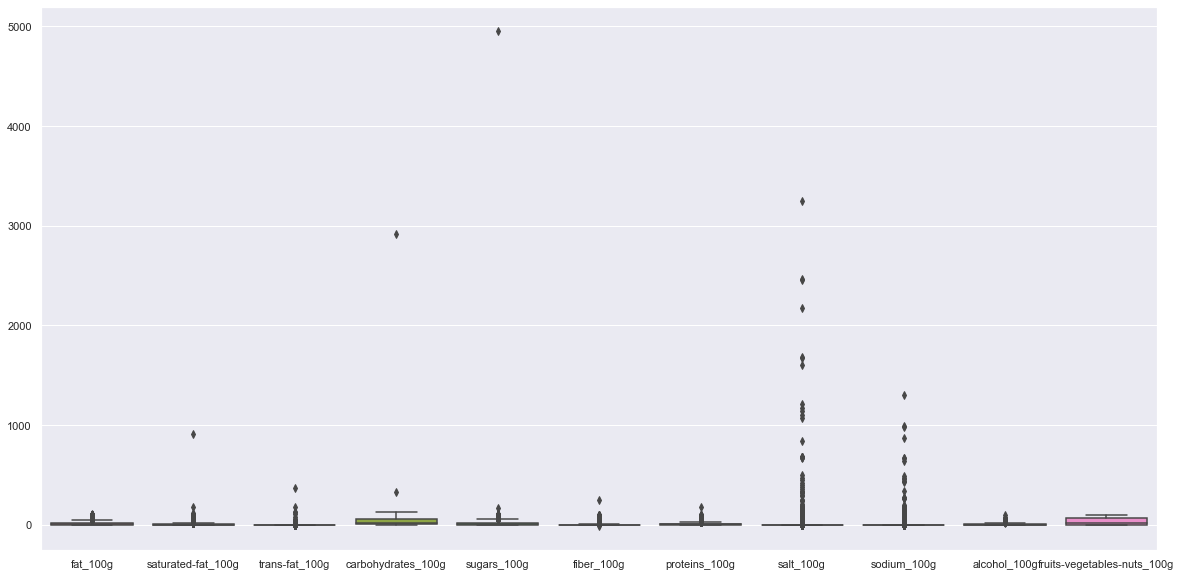

In [17]:
plt.figure(figsize = (20, 10))
sns.boxplot(data = data_int[["fat_100g","saturated-fat_100g","trans-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g","sodium_100g","alcohol_100g","fruits-vegetables-nuts_100g"]])

#### Supprimer les lignes sans nom et/ou code

In [18]:
data_int.loc[data_int["product_name"].isnull()]

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
1275,11110812520,NaN,4.0,NaN,NaN,812.0,2.31,0.00,0.0,38.89,8.33,1.9,5.56,0.625,0.25,NaN,NaN,"Enriched bleached wheat flour (flour, niacin, ...",7.0,http://world-en.openfoodfacts.org/product/0011...
1421,11110825216,NaN,NaN,NaN,NaN,3347.0,93.33,13.33,0.0,0.00,NaN,NaN,0.00,0.000,0.00,NaN,NaN,Extra virgin olive oil.,0.0,http://world-en.openfoodfacts.org/product/0011...
1658,11110841155,NaN,NaN,NaN,NaN,3347.0,93.33,13.33,0.0,0.00,NaN,NaN,0.00,0.000,0.00,NaN,NaN,Organic extra virgin olive oil.,0.0,http://world-en.openfoodfacts.org/product/0011...
1826,11110851130,NaN,NaN,NaN,NaN,3347.0,93.33,13.33,0.0,0.00,0.00,0.0,0.00,0.000,0.00,NaN,NaN,Extra virgin olive oil.,0.0,http://world-en.openfoodfacts.org/product/0011...
1954,11110857736,NaN,NaN,NaN,NaN,3347.0,93.33,13.33,NaN,0.00,NaN,NaN,0.00,0.000,0.00,NaN,NaN,Extra virgin olive oil.,0.0,http://world-en.openfoodfacts.org/product/0011...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253648,9680150261523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9680...
253650,9688084817410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9688...
253653,9691122630827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9691...
253663,98709870987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9870...


In [19]:
data_int.shape

(253678, 20)

In [20]:
data_int.dropna(subset=['code', 'product_name'], inplace=True)

In [21]:
data_int.shape

(249631, 20)

In [22]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,210026.000000,176955.000000,232053.000000,230192.000000,212625.000000,121157.000000,230226.000000,224093.000000,177846.000000,231426.000000,229325.000000,229323.000000,3933.000000,4482.000000,227284.000000
mean,3.393532,8.694340,1111.196973,12.569320,4.877086,0.062588,31.397660,15.372211,2.796605,6.987875,1.704933,0.682226,5.833054,35.880017,2.154828
std,0.989601,9.054399,1310.368648,17.388273,7.968954,1.523171,29.646234,20.876577,4.575501,8.087183,15.834535,6.335079,9.625702,37.713953,3.005940
min,1.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,-6.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,363.000000,0.002500,0.000000,0.000000,5.420000,1.000000,0.000000,0.700000,0.052500,0.021000,0.000000,0.000000,0.000000
50%,4.000000,9.000000,1071.000000,4.929800,1.600000,0.000000,20.000000,5.000000,1.500000,4.620000,0.535000,0.214000,0.000000,22.000000,1.000000
75%,4.000000,15.000000,1670.000000,20.000000,7.000000,0.000000,57.450000,22.730000,3.600000,10.000000,1.322500,0.529000,8.000000,65.000000,3.000000
max,4.000000,38.000000,500000.000000,110.000000,910.000000,369.000000,2916.670000,166.670000,250.000000,175.000000,3250.000000,1300.000000,100.000000,100.000000,32.000000


#### Supprimer les lignes sans données pour les lipides, les glucides et les protéines

In [23]:
df_miss = data_int.loc[(data_int["fat_100g"].isnull() & 
                        data_int["carbohydrates_100g"].isnull() & 
                        data_int["proteins_100g"].isnull())]

df_miss

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
717,11110633606,Sweet Bourbon Flavoured Bratwurst,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"PORK, WATER, CORN SYRUP CONTAINS 2% OR LESS 0F...",2.0,http://world-en.openfoodfacts.org/product/0011...
877,11110712387,Chicken seasoning,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.72,18.288,NaN,NaN,"Salt, spices, paprika, onion*, maltodextrin, d...",0.0,http://world-en.openfoodfacts.org/product/0011...
1316,11110816405,Purified drinking water,1.0,0.0,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,purified water,0.0,http://world-en.openfoodfacts.org/product/0011...
1864,11110852991,Restaurant Style Salsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/0011...
1886,11110853905,Extra Virgin Olive Oil Cooking Spray,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Organic extra virgin olive oil*, organic grain...",1.0,http://world-en.openfoodfacts.org/product/0011...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253669,9906410000009,Roussette du Bugey (2011),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9906...
253671,9918,"Cheese cake thé vert, yuzu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9918...
253672,9935010000003,Rillette d'oie,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"viande d'oie, graisse de canard, épices, sel, ...",0.0,http://world-en.openfoodfacts.org/product/9935...
253674,9948282780603,Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://world-en.openfoodfacts.org/product/9948...


In [24]:
data_int.drop(df_miss.index, axis=0, inplace=True)

#### Traitement des outliers min

In [25]:
data_int.loc[(data_int['trans-fat_100g'] <0 )|
             (data_int['sugars_100g'] <0 )|
             (data_int['proteins_100g'] <0 )|
             (data_int[ 'fiber_100g' ] <0) ]

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
16510,28400231053,Traditional Tender Cracklins Chicharrones,NaN,NaN,NaN,2230.0,33.33,13.33,0.0,0.0,0.0,-6.7,NaN,6.43382,2.573528,NaN,NaN,Fried pork cracklins and salt.,0.0,http://world-en.openfoodfacts.org/product/0028...
158086,3161712000928,Caprice des dieux,3.0,15.0,d,1379.0,30.00,21.00,NaN,0.8,-0.1,NaN,15.3,1.40000,0.560000,NaN,NaN,"_Lait_ de vache, _crème_, sel, ferments lactiq...",0.0,http://world-en.openfoodfacts.org/product/3161...


In [26]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,203116.00000,176551.000000,231755.000000,230192.000000,212527.00000,121154.000000,230226.000000,223992.000000,177841.000000,231426.000000,228987.000000,228985.000000,2252.000000,4453.000000,218984.000000
mean,3.41978,8.713193,1112.083582,12.569320,4.87932,0.062589,31.397660,15.374660,2.796253,6.987875,1.703387,0.681609,1.129089,35.805330,2.207184
std,0.96953,9.055614,1310.788958,17.388273,7.97011,1.523190,29.646234,20.875147,4.572655,8.087183,15.835824,6.335598,5.256990,37.755147,3.028264
min,1.00000,-15.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.100000,-6.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.00000,1.000000,364.000000,0.002500,0.00000,0.000000,5.420000,1.010000,0.000000,0.700000,0.055000,0.022000,0.000000,0.000000,0.000000
50%,4.00000,9.000000,1071.000000,4.929800,1.61000,0.000000,20.000000,5.000000,1.500000,4.620000,0.535000,0.214000,0.000000,22.000000,1.000000
75%,4.00000,15.000000,1671.000000,20.000000,7.00000,0.000000,57.450000,22.730000,3.600000,10.000000,1.327500,0.531000,0.000000,65.000000,3.000000
max,4.00000,38.000000,500000.000000,110.000000,910.00000,369.000000,2916.670000,166.670000,250.000000,175.000000,3250.000000,1300.000000,100.000000,100.000000,32.000000


In [27]:
out_min= ['energy_100g','fat_100g','sugars_100g','proteins_100g', 'fiber_100g' ]

data_int[out_min] = abs(data_int[out_min])

#### Traitement outliers max

In [28]:
df_max = data_int.loc[(data_int['fat_100g'] > 100) |
            (data_int['saturated-fat_100g'] > 100) |
            (data_int['trans-fat_100g'] > 100) |
            (data_int['carbohydrates_100g'] > 100) |
            (data_int['sugars_100g'] > 100) |
            (data_int['proteins_100g'] > 100) |
            (data_int['salt_100g'] > 100) |
            (data_int['fiber_100g'] > 100) | 
            (data_int['sodium_100g'] > 100)]

In [29]:
df_max.shape

(110, 20)

In [30]:
data_int.shape

(232154, 20)

In [31]:
data_int.drop(df_max.index, axis = 0, inplace = True)

In [32]:
data_int.shape

(232044, 20)

In [33]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,203059.000000,176527.000000,231649.000000,230084.000000,212457.000000,121109.000000,230119.000000,223925.000000,177781.000000,231325.000000,228882.000000,228880.000000,2250.000000,4453.000000,218881.000000
mean,3.419839,8.712679,1110.102110,12.572625,4.874331,0.055024,31.385894,15.372692,2.794889,6.988556,1.536542,0.614867,1.130093,35.805330,2.207894
std,0.969519,9.055698,802.331588,17.388825,7.711707,0.742318,29.017914,20.868733,4.534502,8.079205,6.171557,2.471016,5.259219,37.755147,3.028599
min,1.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,364.000000,0.010000,0.000000,0.000000,5.420000,1.010000,0.000000,0.700000,0.055000,0.022000,0.000000,0.000000,0.000000
50%,4.000000,9.000000,1071.000000,4.930000,1.610000,0.000000,20.000000,5.000000,1.500000,4.620000,0.535000,0.214000,0.000000,22.000000,1.000000
75%,4.000000,15.000000,1671.000000,20.000000,7.000000,0.000000,57.450000,22.730000,3.600000,10.000000,1.322500,0.529000,0.000000,65.000000,3.000000
max,4.000000,38.000000,15481.000000,100.000000,100.000000,83.000000,100.000000,100.000000,100.000000,100.000000,100.000000,49.987200,100.000000,100.000000,32.000000


#### Cas particulier

- les graisses saturées et les acide gras ne peuvent pas être supérieur aux graisses
- les sucres ne peuvent pas être supérieur aux glucides

In [34]:
df_part = data_int.loc[(data_int['fat_100g'] < (data_int['saturated-fat_100g'] + data_int['trans-fat_100g'])) |
                       (data_int['carbohydrates_100g'] < data_int['sugars_100g'])]

In [35]:
df_part.shape

(700, 20)

In [36]:
data_int.drop(df_part.index, axis = 0, inplace = True)

In [37]:
data_int.shape

(231344, 20)

In [38]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,202552.000000,176220.000000,230951.00000,229385.000000,211796.000000,120589.000000,229419.000000,223230.000000,177185.000000,230628.000000,228189.000000,228187.000000,2247.000000,4451.000000,218193.000000
mean,3.419566,8.713143,1110.45489,12.578981,4.869099,0.048055,31.421453,15.351275,2.796206,6.986961,1.534703,0.614133,1.131602,35.796727,2.210190
std,0.969744,9.055975,801.91544,17.394254,7.700217,0.573177,29.020864,20.847754,4.529075,8.073091,6.164834,2.468337,5.262568,37.755524,3.030406
min,1.000000,-15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,364.00000,0.020000,0.000000,0.000000,5.420000,1.000000,0.000000,0.700000,0.055000,0.022000,0.000000,0.000000,0.000000
50%,4.000000,9.000000,1071.00000,5.000000,1.610000,0.000000,20.000000,5.000000,1.500000,4.650000,0.535000,0.214000,0.000000,22.000000,1.000000
75%,4.000000,15.000000,1674.00000,20.000000,7.000000,0.000000,57.500000,22.730000,3.600000,10.000000,1.322500,0.529000,0.000000,65.000000,3.000000
max,4.000000,38.000000,15481.00000,100.000000,100.000000,35.710000,100.000000,100.000000,100.000000,100.000000,100.000000,49.987200,100.000000,100.000000,32.000000


#### Visualisation

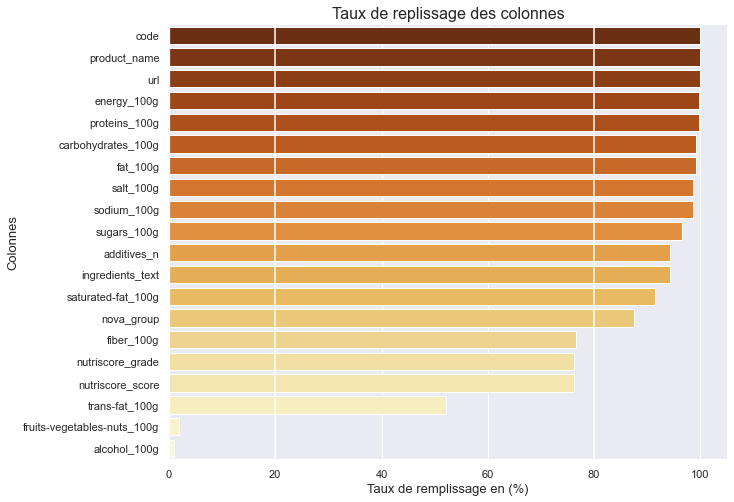

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
Valeurs manquantes,0,0,28792,55124,55124,393,1959,19548,110755,1925,8114,54159,716,3155,3157,229097,226893,13151,13151,0
Nombre de valeurs,231344,231344,202552,176220,176220,230951,229385,211796,120589,229419,223230,177185,230628,228189,228187,2247,4451,218193,218193,231344
Taux de remplissage,100.0,100.0,87.554464,76.17228,76.17228,99.830123,99.153209,91.550246,52.125406,99.167906,96.492669,76.589408,99.690504,98.63623,98.635366,0.971281,1.923975,94.315392,94.315392,100.0
Valeurs différentes,231247,179813,4,54,5,3505,4492,2922,358,7193,5383,1473,3539,9115,8970,83,734,183719,33,231343


In [39]:
visu(data_int)

### Imputation

#### Imputation par 0

In [40]:
imp = ['fiber_100g',
       'alcohol_100g',
       'fruits-vegetables-nuts_100g',
       'additives_n']

In [41]:
for i in imp:
    data_int[i].fillna(0, inplace=True) #remplace les valeurs manquantes par 0
    
data_int['ingredients_text'].fillna('0',inplace= True) 

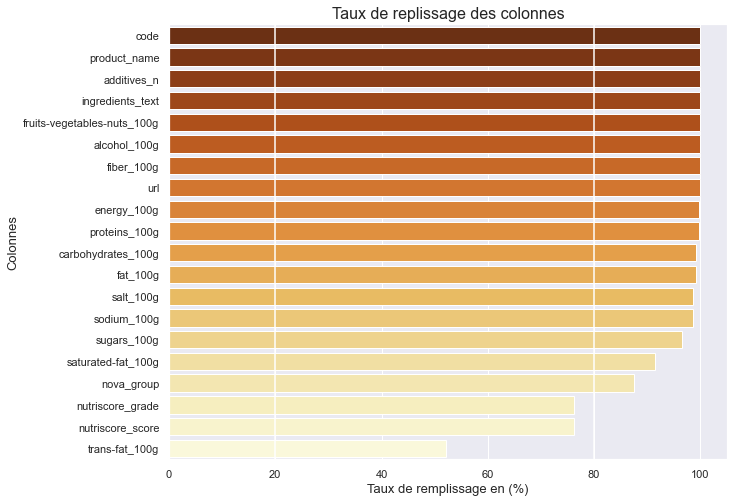

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
Valeurs manquantes,0,0,28792,55124,55124,393,1959,19548,110755,1925,8114,0,716,3155,3157,0,0,0,0,0
Nombre de valeurs,231344,231344,202552,176220,176220,230951,229385,211796,120589,229419,223230,231344,230628,228189,228187,231344,231344,231344,231344,231344
Taux de remplissage,100.0,100.0,87.554464,76.17228,76.17228,99.830123,99.153209,91.550246,52.125406,99.167906,96.492669,100.0,99.690504,98.63623,98.635366,100.0,100.0,100.0,100.0,100.0
Valeurs différentes,231247,179813,4,54,5,3505,4492,2922,358,7193,5383,1473,3539,9115,8970,83,734,183719,33,231343


In [42]:
visu(data_int)

In [43]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,202552.000000,176220.000000,230951.00000,229385.000000,211796.000000,120589.000000,229419.000000,223230.000000,231344.000000,230628.000000,228189.000000,228187.000000,231344.000000,231344.00000,231344.000000
mean,3.419566,8.713143,1110.45489,12.578981,4.869099,0.048055,31.421453,15.351275,2.141598,6.986961,1.534703,0.614133,0.010991,0.68872,2.084549
std,0.969744,9.055975,801.91544,17.394254,7.700217,0.573177,29.020864,20.847754,4.136703,8.073091,6.164834,2.468337,0.530274,7.18328,2.987177
min,1.000000,-15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.000000,1.000000,364.00000,0.020000,0.000000,0.000000,5.420000,1.000000,0.000000,0.700000,0.055000,0.022000,0.000000,0.00000,0.000000
50%,4.000000,9.000000,1071.00000,5.000000,1.610000,0.000000,20.000000,5.000000,0.300000,4.650000,0.535000,0.214000,0.000000,0.00000,1.000000
75%,4.000000,15.000000,1674.00000,20.000000,7.000000,0.000000,57.500000,22.730000,2.900000,10.000000,1.322500,0.529000,0.000000,0.00000,3.000000
max,4.000000,38.000000,15481.00000,100.000000,100.000000,35.710000,100.000000,100.000000,100.000000,100.000000,100.000000,49.987200,100.000000,100.00000,32.000000


<AxesSubplot:>

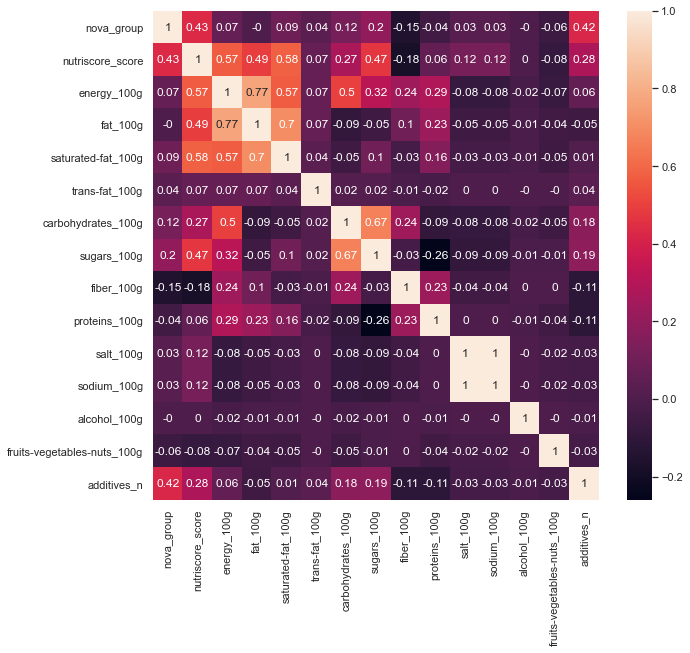

In [44]:
plt.figure(figsize= (10,9))
sns.heatmap (data_int.corr().round(2), annot=True )

#### Calcul des énergies manquantes

    Calcul pour 100g:
        Energy(kcal) = 9*fats + 4*Carbohydrates + 4*protein
        Energy(kJ) = 4,1868*Energy(kcal)
        L'energie ne peut pas dépasser les 3768 kJ

In [45]:
for l, r in data_int.loc[data_int['energy_100g'].isnull() | (data_int['energy_100g']> 3769)].iterrows():
    r['energy_100g'] = ((9*r['fat_100g'] + 4*r['carbohydrates_100g'] + 4*r['proteins_100g']) * 4.1868)
    data_int.loc[l,'energy_100g'] = r['energy_100g']

In [46]:
df_energ = data_int.loc[(data_int['energy_100g']> 3769)]
data_int.drop(df_energ.index, axis = 0, inplace = True)

In [47]:
data_int.describe()

,nova_group,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,additives_n
count,202550.000000,176218.000000,231099.000000,229373.000000,211786.000000,120579.000000,229407.000000,223218.000000,231332.000000,230616.000000,228177.00000,228175.000000,231332.000000,231332.000000,231332.000000
mean,3.419570,8.713066,1108.808646,12.575227,4.868321,0.047995,31.420421,15.350906,2.141346,6.986155,1.53470,0.614131,0.010992,0.688756,2.084653
std,0.969743,9.055985,796.644980,17.386696,7.697844,0.572983,29.020468,20.847173,4.136399,8.072279,6.16498,2.468395,0.530288,7.183465,2.987219
min,1.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,364.000000,0.020000,0.000000,0.000000,5.420000,1.000000,0.000000,0.700000,0.05500,0.022000,0.000000,0.000000,0.000000
50%,4.000000,9.000000,1071.000000,5.000000,1.610000,0.000000,20.000000,5.000000,0.300000,4.650000,0.53500,0.214000,0.000000,0.000000,1.000000
75%,4.000000,15.000000,1670.000000,20.000000,7.000000,0.000000,57.500000,22.730000,2.900000,10.000000,1.32250,0.529000,0.000000,0.000000,3.000000
max,4.000000,38.000000,3768.120000,100.000000,100.000000,35.710000,100.000000,100.000000,100.000000,100.000000,100.00000,49.987200,100.000000,100.000000,32.000000


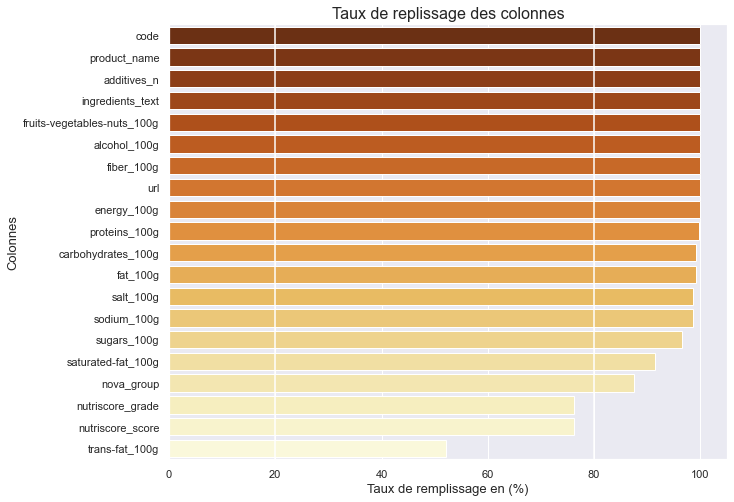

,code,product_name,nova_group,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits-vegetables-nuts_100g,ingredients_text,additives_n,url
Valeurs manquantes,0,0,28782,55114,55114,233,1959,19546,110753,1925,8114,0,716,3155,3157,0,0,0,0,0
Nombre de valeurs,231332,231332,202550,176218,176218,231099,229373,211786,120579,229407,223218,231332,230616,228177,228175,231332,231332,231332,231332,231332
Taux de remplissage,100.0,100.0,87.558142,76.175367,76.175367,99.899279,99.153165,91.550672,52.123787,99.167863,96.492487,100.0,99.690488,98.636159,98.635295,100.0,100.0,100.0,100.0,100.0
Valeurs différentes,231235,179805,4,54,5,3602,4491,2922,358,7193,5383,1473,3539,9115,8970,83,734,183709,33,231331


In [48]:
visu(data_int)

#### Supprimer les 

In [49]:
df_100g = data_int.loc[(data_int['fat_100g'] + data_int['carbohydrates_100g'] + data_int['proteins_100g']) > 100]
df_100g.shape

(1410, 20)

In [50]:
data_int.drop(df_100g.index, axis = 0, inplace = True)

### KNNImputer

In [51]:
data_int.reset_index(drop=True, inplace=True)

In [52]:
cor = data_int[['energy_100g',
                'fat_100g',
                'saturated-fat_100g',
                'trans-fat_100g',
                'carbohydrates_100g',
                'sugars_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
               'sodium_100g']] 

In [53]:
plt.figure(figsize= (7,5))
sns.heatmap(cor.corr().round(2), annot=True)

<AxesSubplot:>

Error in callback <function flush_figures at 0x000001DF7A41B5E0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
imputer0 = KNNImputer(n_neighbors=5) #Fixé a 5 voisins
imputer0.fit(data_int[['energy_100g','fat_100g',
                'saturated-fat_100g',
                'trans-fat_100g',
                'carbohydrates_100g',
                'sugars_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
               'sodium_100g']])
train = imputer0.transform(data_int[['energy_100g','fat_100g',
                'saturated-fat_100g',
                'trans-fat_100g',
                'carbohydrates_100g',
                'sugars_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
               'sodium_100g']])
print(sum(isnan(train).flatten()))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Steph\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-27e7591888da>", line 11, in <module>
    train = imputer0.transform(data_int[['energy_100g','fat_100g',
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\impute\_knn.py", line 297, in transform
    for chunk in gen:
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1623, in pairwise_distances_chunked
    D_chunk = pairwise_distances(X_chunk, Y, metric=metric,
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1790, in pairwise_distances
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Steph\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-27e7591888da>", line 11, in <module>
    train = imputer0.transform(data_int[['energy_100g','fat_100g',
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\impute\_knn.py", line 297, in transform
    for chunk in gen:
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1623, in pairwise_distances_chunked
    D_chunk = pairwise_distances(X_chunk, Y, metric=metric,
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1790, in pairwise_distances
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\Steph\anaconda3\lib\site-packages\sklearn\metrics

In [54]:
df_train = pd.DataFrame(train, columns = ['energy_100g','fat_100g',
                'saturated-fat_100g',
                'trans-fat_100g',
                'carbohydrates_100g',
                'sugars_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
               'sodium_100g'])

ERROR! Session/line number was not unique in database. History logging moved to new session 185


NameError: name 'train' is not defined

In [ ]:
visu(df_train)

In [ ]:
df_first = data_int[["code", "product_name", 'nova_group',
            'nutriscore_score',
            'nutriscore_grade']]
df_last =  data_int[["alcohol_100g","fruits-vegetables-nuts_100g","ingredients_text","additives_n","url"]]

In [ ]:
df_knn= pd.concat([df_first, df_train, df_last], axis=1)

In [ ]:
visu(df_knn)

In [ ]:
df_knn.describe()

In [ ]:
df_out = df_knn.loc[((df_knn['fat_100g'] + df_knn['carbohydrates_100g'] + df_knn['proteins_100g']) > 100) | df_knn["product_name"].isnull()]
df_out.shape

In [ ]:
df_knn.drop(df_out.index, axis = 0, inplace = True)

In [ ]:
df_knn.shape

In [ ]:
df_knn.reset_index(drop=True, inplace=True)

In [ ]:
plt.figure(figsize=(11,10))
sns.heatmap(df_knn.corr(), annot=True)

In [ ]:
cor0 = df_knn[['nutriscore_score','energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g']]

In [ ]:
sns.heatmap(cor0.corr(), annot= True)

In [ ]:
imputed_dataset = imputer0.fit_transform(cor0)
df_imp = pd.DataFrame(imputed_dataset, columns = cor0.columns)
df_imp.describe()

In [ ]:
df_imp.isnull().sum()

In [ ]:
df_imp.shape

In [ ]:
df_kf = df_knn[['code','product_name','nova_group',
            'nutriscore_grade']]
df_kl = df_knn[['trans-fat_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
                'sodium_100g',
                "alcohol_100g",
                "fruits-vegetables-nuts_100g",
                "ingredients_text",
                "additives_n",
                "url"]]
df_it = pd.concat([df_kf, df_imp, df_kl], axis=1)
df_it.shape

In [ ]:
visu(df_it)

## Iterative Imputer

In [ ]:
cor1 = df_it[['nova_group','nutriscore_score','additives_n']]

In [ ]:
sns.heatmap(cor1.corr(), annot=True)

In [ ]:
imputer1 = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer1.fit_transform(cor1)
df_ite = pd.DataFrame(imputed_dataset, columns = cor1.columns)
df_ite.describe()

In [ ]:
df_if = df_it[['code','product_name']]
df_il = df_it[['nutriscore_grade','energy_100g',
               'fat_100g',
                'saturated-fat_100g',
                'trans-fat_100g',
                'carbohydrates_100g',
                'sugars_100g',
                'fiber_100g',
                'proteins_100g',
                'salt_100g',
                'sodium_100g',
                "alcohol_100g",
                "fruits-vegetables-nuts_100g",
                "ingredients_text",
                "url"]]
df_final = pd.concat([df_if, df_ite, df_il], axis=1)
df_final.shape

### Nutriscore grade

In [ ]:
for l, r in df_final.loc[df_final["nutriscore_grade"].isnull()].iterrows():
    if r['nutriscore_score'] < 0:
        df_final.loc[l,"nutriscore_grade"] = 'a'
    elif -1 < r['nutriscore_score'] < 3:
        df_final.loc[l,"nutriscore_grade"] = 'b'
    elif 2 < r['nutriscore_score'] < 11:
        df_final.loc[l,"nutriscore_grade"] = 'c'
    elif 10 < r['nutriscore_score'] < 19:
        df_final.loc[l,"nutriscore_grade"] = 'd'
    else:
        df_final.loc[l,"nutriscore_grade"] = 'e'   

In [ ]:
visu(df_final)

In [ ]:
df_final.describe()

In [ ]:
df_ex= df_final.loc[(df_final['fat_100g'] < (df_final['saturated-fat_100g'] + df_final['trans-fat_100g'])) |
                       (df_final['carbohydrates_100g'] < df_final['sugars_100g']) | 
                    ((df_final['fat_100g'] + df_final['carbohydrates_100g'] + df_final['proteins_100g'])>100)]
df_ex.shape

In [ ]:
df_final.drop(df_ex.index, axis=0, inplace = True)

In [ ]:
df_final[['nova_group','nutriscore_score']] = df_final[['nova_group','nutriscore_score']].astype('int')

In [ ]:
df_final.rename(columns={
      "code": "Code",
      "product_name": "Nom du produit",
      "nova_group" : "Groupe NOVA",
      "nutriscore_score" : "Nutrition Score",
      "additives_n": "Additifs",
      "nutriscore_grade": "Nutri-Score",
      "energy_100g": "Energie",
      "fat_100g": "Lipides",
      "saturated-fat_100g": "Graisses saturées", 
      "trans-fat_100g": "Acides gras",
      "carbohydrates_100g": "Glucides",
      "sugars_100g" : "Sucres",
      "fiber_100g" : "Fibres",
      "proteins_100g" : "Protéïnes",
      "salt_100g" : "Sel",
      "sodium_100g" : "Sodium",
      "alcohol_100g" : "Alcool",
      "fruits-vegetables-nuts_100g" : "Fruits-Légumes-Noix",
      "ingredients_text" : "Ingrédients",
      "url" : "URL"}, inplace=True)

In [ ]:
df_final.dtypes

In [ ]:
df_final.describe()

In [ ]:
visu(df_final)

In [ ]:
df_final.to_csv("./Data/DonnéesNettoyées.csv")